In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import seaborn as sns
from sklearn.ensemble import IsolationForest

C:\Users\graykar\Documents\Annaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
House_Data = pd.read_csv("C:\\Users\\graykar\\Downloads\\Pyhton\\Data Files\\Housing Price.csv")

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( House_Data , House_Data['SalePrice'] , test_size=0.20, random_state=1,)

In [5]:
#Drop Feature which has more nulls
v_null_drop = X_train.isnull().mean()[X_train.isnull().mean() > 0.90].index
X_train.drop(v_null_drop , inplace=True, axis=1)

#Drop Less Variance Feature
X_train_Num_Col = X_train.dtypes.index
v_low_var_set = []
for i in X_train_Num_Col:
    v_count = X_train[i].value_counts(normalize=True)[X_train[i].value_counts(normalize=True) > 0.80].count()
    if v_count > 0 :
        v_low_var_set.append(i)
X_train.drop(v_low_var_set, axis=1, inplace=True)

#Drop Id Column 
X_train.drop(['Id'], axis=1, inplace=True)

#Drop Less Correlated columns
v_corr_drop = X_train.corr()['SalePrice'][abs(X_train.corr()['SalePrice']) < 0.25].index
X_train.drop(v_corr_drop, axis=1 , inplace=True)

C:\Users\graykar\Documents\Annaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [6]:
X_train.isna().sum()[X_train.isna().sum() > 0]

LotFrontage     209
MasVnrType        8
MasVnrArea        8
BsmtQual         30
BsmtExposure     31
BsmtFinType1     30
FireplaceQu     548
GarageType       61
GarageYrBlt      61
GarageFinish     61
Fence           954
dtype: int64

In [7]:
X_train['GarageYrBlt'] = 2020 - X_train['GarageYrBlt']

LotFrontage_Imputation = X_train.LotFrontage.median()
MasVnrType_Imputation = X_train['MasVnrType'].mode().values[0]
MasVnrArea_Imputation = X_train['MasVnrArea'].mode().values[0]

X_train['LotFrontage'].fillna( LotFrontage_Imputation ,  inplace=True)
X_train['MasVnrType'].fillna(MasVnrType_Imputation,  inplace=True)
X_train['MasVnrArea'].fillna(MasVnrArea_Imputation,  inplace=True)

X_train['BsmtQual'].fillna('NB',  inplace=True)
X_train['BsmtExposure'].fillna('NB',  inplace=True)
X_train['BsmtFinType1'].fillna('NB',  inplace=True)
X_train['FireplaceQu'].fillna('NB',  inplace=True)
X_train['GarageType'].fillna('NG',  inplace=True)
X_train['GarageYrBlt'].fillna(40,  inplace=True)
X_train['GarageFinish'].fillna('NG',  inplace=True)
X_train['Fence'].fillna('NA',  inplace=True)


C:\Users\graykar\Documents\Annaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\graykar\Documents\Annaconda3\lib\site-packages\pandas\core\generic.py:5430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [8]:
X_train.isna().sum()[X_train.isna().sum() > 0]

Series([], dtype: int64)

In [10]:
v_log_transform_col = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1',
                       '2ndFlrSF','GrLivArea','HalfBath','TotRmsAbvGrd','Fireplaces','GarageYrBlt',
                       'WoodDeckSF','OpenPorchSF','SalePrice']

In [11]:
for i in v_log_transform_col:
    X_train[i] = np.log(X_train[i]+1)

C:\Users\graykar\Documents\Annaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [12]:
# Drop Multi-Colinearity columns

X_train.drop(['1stFlrSF','GarageArea'] , axis=1, inplace=True)

C:\Users\graykar\Documents\Annaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [18]:
v_rare_list = []
for i in X_train.dtypes[X_train.dtypes =='object'].index:
    v_cnt = X_train[i].value_counts(normalize=True)[X_train[i].value_counts(normalize=True) <= 0.03].count()
    if v_cnt >= 1:
        #print(i)
        v_rare_list.append(i)
v_rare_list
for j in v_rare_list:
    print(j)
    X_train[j] = X_train[j].mask(X_train[j].map(X_train[j].value_counts(normalize=True) < 0.03),X_train[j].mode().values[0])
    X_test[j] = X_test[j].mask(X_test[j].map(X_test[j].value_counts(normalize=True) < 0.03),X_test[j].mode().values[0])


MSZoning


C:\Users\graykar\Documents\Annaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\graykar\Documents\Annaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


LotShape
LotConfig
Neighborhood
HouseStyle
RoofStyle
Exterior1st
Exterior2nd
MasVnrType
ExterQual
Foundation
BsmtQual
BsmtExposure
BsmtFinType1
KitchenQual
FireplaceQu
GarageType
Fence


In [22]:
v_high_cardinal_col = []
for i in X_train.dtypes[ X_train.dtypes == 'object'].index:
    i_train , i_test = [], []
    i_train = X_train[i].value_counts().index.tolist()
    i_test = X_test[i].value_counts().index.tolist()
    i_train.sort()
    i_test.sort()

    if i_train == i_test: 
        continue
    else :
        print ("The lists are not identical " + i , set(i_train) - set(i_test) , '- - ',  set(i_test) - set(i_train)  )
        v_high_cardinal_col.append(i)
    i_train.clear()
    i_test.clear()


In [ ]:
X_train.SaleCondition.value_counts(normalize=True)

In [21]:
X_train.loc[X_train.Neighborhood == 'Crawfor'  , 'Neighborhood'] = X_train.Neighborhood.mode().values[0]
X_test.loc[X_test.Neighborhood == 'NoRidge'  , 'Neighborhood'] = X_train.Neighborhood.mode().values[0]
X_test.loc[X_test.Neighborhood == 'Mitchel'  , 'Neighborhood'] = X_train.Neighborhood.mode().values[0]
X_test.loc[X_test.Neighborhood == 'IDOTRR'  , 'Neighborhood'] = X_train.Neighborhood.mode().values[0]
X_test.loc[X_test.LotConfig == 'FR2'  , 'LotConfig'] = X_train.LotConfig.mode().values[0]
X_test.loc[X_test.BsmtQual == 'Fa'  , 'BsmtQual'] = X_train.BsmtQual.mode().values[0]
X_test.loc[X_test.HeatingQC == 'Po'  , 'HeatingQC'] = X_train.HeatingQC.mode().values[0]
X_test.loc[X_test.KitchenQual == 'Fa'  , 'KitchenQual'] = X_train.KitchenQual.mode().values[0]

C:\Users\graykar\Documents\Annaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [ ]:
X_train.loc[X_train.Neighborhood == 'NPkVill'  , 'Neighborhood'] = X_train.Neighborhood.mode().values[0]
X_train.loc[X_train.Exterior1st == 'Stone'  , 'Exterior1st'] = X_train.Exterior1st.mode().values[0]
X_train.loc[X_train.Foundation  == 'Stone'  , 'Foundation'] = X_train.Foundation.mode().values[0]
X_train.loc[X_train.Foundation  == 'Wood'  , 'Foundation'] = X_train.Foundation.mode().values[0]
X_train.loc[X_train.GarageQual == 'Po'  , 'GarageQual'] = X_train.GarageQual.mode().values[0]
X_train.loc[X_train.Condition1 == 'PosA'  , 'Condition1'] = X_train.Condition1.mode().values[0]
X_test.loc[X_test.Exterior1st == 'AsphShn'  , 'Exterior1st'] = X_test.Exterior1st.mode().values[0]

In [ ]:
X_train.loc[X_train.Condition1 == 'RRNe'  , 'Condition1'] = 'RRAn'
X_train.loc[X_train.RoofStyle == 'Mansard'  , 'RoofStyle'] = 'Hip'
#X_train.loc[X_train.Exterior1st == 'AsphShn'  , 'Exterior1st'] = 'AsbShng'
X_train.loc[X_train.Exterior1st == 'ImStucc'  , 'Exterior1st'] = 'Stucco'
X_train.loc[X_train.Exterior1st == 'CBlock'  , 'Exterior1st'] = 'WdShing'
#X_train.loc[X_train.Exterior1st == 'BrkComm'  , 'Exterior1st'] = 'BrkFace'
#X_test.loc[X_test.Exterior1st == 'Stone'  , 'Exterior1st'] = 'BrkFace'
X_train.loc[X_train.Exterior2nd == 'CBlock'  , 'Exterior2nd'] = 'Wd Shng'
X_train.loc[X_train.Exterior2nd == 'Other'  , 'Exterior2nd'] = 'Brk Cmn'
#X_train.loc[X_train.Exterior2nd == 'AsphShn'  , 'Exterior2nd'] = 'Stone'
X_train.loc[X_train.ExterCond == 'Ex'  , 'ExterCond'] = 'Fa'
X_train.loc[X_train.ExterCond == 'Po'  , 'ExterCond'] = 'Fa'
#X_train.loc[X_train.BsmtCond == 'Po'  , 'BsmtCond'] = 'NB'
X_test.loc[X_test.HeatingQC == 'Po'  , 'HeatingQC'] = 'Fa'
X_train.loc[X_train.Electrical == 'Mix'  , 'Electrical'] = 'FuseP'
X_train.loc[X_train.Functional == 'Maj2'  , 'Functional'] = 'Mod'
X_train.loc[X_train.Functional == 'Sev'  , 'Functional'] = 'Mod'
X_train.loc[X_train.SaleType == 'Con'  , 'SaleType'] = 'New'
#X_train.loc[X_train.SaleCondition == 'AdjLand'  , 'SaleCondition'] = 'Alloca'

In [26]:
v_label_enco = ['LotShape','ExterQual','BsmtQual','BsmtExposure','BsmtFinType1','HeatingQC',
                'KitchenQual','FireplaceQu','GarageFinish','Fence']
v_Onehot_enco = ['LotConfig','Neighborhood','HouseStyle','RoofStyle','Exterior1st',
                 'Exterior2nd','MasVnrType','Foundation','GarageType','MSZoning']

len(v_label_enco) , len(v_Onehot_enco)

(10, 10)

In [24]:
cat_list_dict = { 'LotShape' : ['Reg','IR1','IR2','IR3'],
'ExterQual' : ['TA','Gd','Ex','Fa'],
'BsmtQual' : ['TA','Gd','Ex','Fa'],
'BsmtExposure' : ['Av','No','Gd','Mn'],
'BsmtFinType1' : ['BLQ','GLQ','Unf','Rec','ALQ','LwQ'],
'HeatingQC' : ['TA','Ex','Gd','Fa'],
'KitchenQual' : ['TA','Ex','Gd','Fa'],
'FireplaceQu' : ['Missing','TA','Gd','Fa','Po','Ex'],
'GarageFinish' : ['Unf','RFn','Fin'],
'ExterCond' :  ['TA' ,'Gd' ,'Rare'],
'BsmtCond' : ['TA', 'Rare'],
'BsmtFinType2' : ['Unf' ,'ALQ', 'Rec' ,'BLQ', 'GLQ' ,'LwQ', 'NB'],
'PavedDrive' : ['Y', 'P' ,'N'],
'Fence' : ['NA' ,'GdWo', 'GdPrv' ,'MnPrv', 'MnWw']}

In [25]:
for i in X_train.dtypes[ X_train.dtypes == 'object'].index:
    print( len(X_train[i].value_counts()) , i )

3 MSZoning
2 LotShape
3 LotConfig
11 Neighborhood
4 HouseStyle
2 RoofStyle
7 Exterior1st
6 Exterior2nd
3 MasVnrType
3 ExterQual
3 Foundation
3 BsmtQual
4 BsmtExposure
6 BsmtFinType1
4 HeatingQC
3 KitchenQual
3 FireplaceQu
4 GarageType
4 GarageFinish
4 Fence


In [27]:
def label_encoding (df, column):
    df[column] = pd.Categorical(df[column] , categories = cat_list_dict[column])
    df[column] = df[column].cat.codes

In [28]:
for i in v_label_enco:
    label_encoding(X_train, i)

C:\Users\graykar\Documents\Annaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\graykar\Documents\Annaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [29]:
# One hot Encoding
for i in v_Onehot_enco:
    X_train = pd.get_dummies(X_train,columns=[i] , prefix= [i] , drop_first=True)

In [30]:
X_train.head()

,LotFrontage,LotArea,LotShape,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,BsmtQual,BsmtExposure,...,Exterior2nd_Wd Sdng,MasVnrType_None,MasVnrType_Stone,Foundation_CBlock,Foundation_PConc,GarageType_BuiltIn,GarageType_Detchd,GarageType_NG,MSZoning_RL,MSZoning_RM
921,4.219508,9.080004,0,5,1900,2003,0.000000,0,0,1,...,0,1,0,1,0,0,0,1,1,0
520,4.110874,9.287394,0,4,1900,2000,0.000000,0,1,1,...,0,1,0,0,0,0,0,1,1,0
401,4.189655,9.078864,1,7,2005,2005,0.000000,1,1,0,...,0,1,0,0,1,0,0,0,1,0
280,4.418841,9.331495,0,7,1989,1989,5.831882,1,1,0,...,0,0,0,1,0,0,0,0,1,0
1401,4.143135,8.911395,1,6,2004,2004,0.000000,0,0,1,...,0,1,0,0,1,0,0,0,1,0


In [31]:
train_X = X_train.loc[: , [x for x in X_train.columns if x not in ['SalePrice']] ]
train_y = y_train

In [32]:
train_X.shape , train_y.shape

((1168, 64), (1168,))

In [33]:
LR = LinearRegression()
LR.fit(train_X , train_y)
y_pred = LR.predict(train_X)

r2_score(train_y, y_pred)

0.8308200305539912

# Test Set Implimentation

In [14]:
X_test.drop(v_null_drop , axis=1, inplace=True)
X_test.drop(v_low_var_set , axis=1, inplace=True)
X_test.drop(v_corr_drop , axis=1, inplace=True)
X_test.drop(['Id'], axis=1, inplace=True)

C:\Users\graykar\Documents\Annaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [15]:
X_test['GarageYrBlt'] = 2020 - X_test['GarageYrBlt']

LotFrontage_Imputation = X_test.LotFrontage.median()
MasVnrType_Imputation = X_test['MasVnrType'].mode().values[0]
MasVnrArea_Imputation = X_test['MasVnrArea'].mode().values[0]

X_test['LotFrontage'].fillna( LotFrontage_Imputation ,  inplace=True)
X_test['MasVnrType'].fillna(MasVnrType_Imputation,  inplace=True)
X_test['MasVnrArea'].fillna(MasVnrArea_Imputation,  inplace=True)

X_test['BsmtQual'].fillna('NB',  inplace=True)
X_test['BsmtExposure'].fillna('NB',  inplace=True)
X_test['BsmtFinType1'].fillna('NB',  inplace=True)
X_test['FireplaceQu'].fillna('NB',  inplace=True)
X_test['GarageType'].fillna('NG',  inplace=True)
X_test['GarageYrBlt'].fillna(40,  inplace=True)
X_test['GarageFinish'].fillna('NG',  inplace=True)
X_test['Fence'].fillna('NA',  inplace=True)


C:\Users\graykar\Documents\Annaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\graykar\Documents\Annaconda3\lib\site-packages\pandas\core\generic.py:5430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [16]:
# Drop Multi-Colinearity columns

X_test.drop(['1stFlrSF','GarageArea'] , axis=1, inplace=True)

C:\Users\graykar\Documents\Annaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [17]:
for i in v_log_transform_col:
    X_test[i] = np.log(X_test[i]+1)

C:\Users\graykar\Documents\Annaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [34]:
# Label Encoding
for i in v_label_enco:
    label_encoding(X_test, i)
# One hot Encoding
for i in v_Onehot_enco:
    X_test = pd.get_dummies(X_test,columns=[i] , prefix= [i] , drop_first=True)

C:\Users\graykar\Documents\Annaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\graykar\Documents\Annaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [35]:
X_test.head()

,LotFrontage,LotArea,LotShape,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,BsmtQual,BsmtExposure,...,Exterior2nd_Wd Sdng,MasVnrType_None,MasVnrType_Stone,Foundation_CBlock,Foundation_PConc,GarageType_BuiltIn,GarageType_Detchd,GarageType_NG,MSZoning_RL,MSZoning_RM
258,4.394449,9.428351,0,7,2001,2001,5.153292,1,1,1,...,0,0,0,0,1,0,0,0,1,0
267,4.110874,9.036106,0,5,1939,1997,0.000000,0,0,1,...,1,1,0,0,1,0,1,0,1,0
288,4.262680,9.192176,1,5,1967,1967,3.465736,0,0,1,...,0,0,0,1,0,0,1,0,1,0
649,3.091042,7.568896,0,4,1970,1970,0.000000,0,1,0,...,0,1,0,1,0,0,0,1,0,1
1233,4.262680,9.405989,1,5,1959,1959,5.198497,0,0,1,...,0,0,0,1,0,0,0,0,1,0


In [36]:
test_X = X_test.loc[: , [x for x in X_test.columns if x not in ['SalePrice']] ]
test_y = y_test

In [37]:
train_X.shape , test_X.shape

((1168, 64), (292, 64))

In [38]:
X_train.columns == X_test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [39]:
y_test_pred = LR.predict(test_X)

r2_score(test_y, y_test_pred)

0.8145326684142881

In [40]:
from sklearn.metrics import mean_squared_error

def plot_learning_curves():
    train_errors, test_errors = [], []
    for m in range(1, len(train_X)):
        LR.fit(train_X[:m], train_y[:m])
        train_prediction = LR.predict(train_X[:m])
        test_prediction = LR.predict(test_X)
        train_errors.append(np.sqrt(mean_squared_error(train_prediction, train_y[:m])))
        test_errors.append(np.sqrt(mean_squared_error(test_prediction, test_y)))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(test_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   
    plt.xlabel("Training set size", fontsize=14) 
    plt.ylabel("RMSE", fontsize=14)

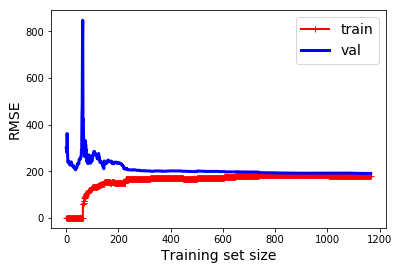

In [41]:
plot_learning_curves()